# Compute vibrational energies of OCS using variational method

- Expand vibrational wavefunctions in linear combination of products of one-dimensional basis functions for each vibrational coordinate:
  $$ \Psi_l(x_1,x_2,x_3) = \sum_{i,j,k} c_{i,j,k}^{(l)}\phi_i^{(1)}(x_1)\phi_j^{(2)}(x_2)\phi_k^{(3)}(x_3).$$

- Our task is to find the linear expansion coefficients $c_{i,j,k}^{(l)}$ and the corresponding vibrational energies $E_l$ by solving the stationary Schrödinger equation:
  $$(\hat{T}+V)\Psi_l = E_l\Psi_l.$$

- This is equivalent to solving the eigenvalue problem:

  $$ (\mathbf{T}+\mathbf{V})\mathbf{C} = \mathbf{E}\mathbf{S}\mathbf{C},$$

  where

  $$
  T_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}\hat{T}\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3 =
  -\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}
  \frac{\partial}{\partial x_\lambda}
  G_{\lambda,\mu}\frac{\partial}{\partial x_\mu}
  \phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3,
  $$
  (see details in [ocs_coordinates.ipynb](ocs_coordinates.ipynb)),

  $$V_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}V\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3,$$

  and

  $$S_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dx_1dx_2dx_3.$$

In the following we address two key challenges: (1) selecting the appropriate basis functions for each coordinate, and (2) calculating the corresponding matrix elements.

In [72]:
import import_ipynb

In [73]:
from numpy.polynomial.legendre import leggauss, legval, legder
from numpy.polynomial.laguerre import laggauss, lagval, lagder
import numpy as np
from scipy import constants
import itertools
from typing import Optional, Tuple

from kinetic import Gmat_batch
from ocs_coordinates import jacobi_to_cartesian
from ocs_potential import potentials

import jax
from jax import numpy as jnp
from jax import config

config.update("jax_enable_x64", True)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [74]:
# Matplotlib settings
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams["figure.figsize"] = (6, 6)

# Physics units conversion factors
hartree_to_invcm = constants.value('hartree-inverse meter relationship') / 100

## One-dimensional basis functions and Gaussian quadratures

- Orthogonal polynomials ([Wiki page](https://en.wikipedia.org/wiki/Orthogonal_polynomials)):
$$\int W(x)P_i(x)P_j(x)dx=N_i\delta_{ij}$$

- Examples of classical orthogonal polynomials:

    |Weight function | Polynomial | Ranges |
    |:-:|:-:|:-:|
    |$e^{-x^2}$| Hermite | $[-\infty,\infty]$|
    | 1| Legendre | [-1, 1]|
    |$e^{-x}$ | Laguerre | $[0, \infty]$ |
    |$\sqrt{1-x^2}$ | Chebyshev | $[-1, 1]$|
    |$(1-x)^\alpha(1+x)^\beta,~\alpha,\beta>-1$| Jacobi | $[-1, 1]$|

- Build basis functions from orthogonal polynomials:
$$\phi_j(x) = \sqrt{W(x)}P_j(x),$$

$$\langle \phi_i|\phi_j\rangle = \int W(x)P_i(x)P_j(x)dx=N_i\delta_{ij}.$$

- Gaussian quadratures for integration:

$$\int W(x)f(P(x))dx=\sum_g^{N_g} w_g f(x_g),$$

$$\langle \phi_i|V|\phi_j\rangle = \int W(x)\underbrace{P_i(x)P_j(x)V(x)}_{f(P(x))}dx\approx \sum_g^{N_g} w_g P_i(x_g)P_j(x_g)V(x_g)= \sum_g^{N_g} \frac{w_g}{W(x_g)} \phi_i(x_g)\phi_j(x_g)V(x_g).$$

Few examples of classical polynomials (Legendre, Laguerre, Hermite), that we will use as basis functions for the $r_\text{S}$, $r_\text{CO}$, and $\theta$ vibrational Jacobi coordinates.

In [75]:
def legendre(nmax: int, x: np.ndarray) -> np.ndarray:
    """Legendre functions, shape = (nmax, len(x))"""
    c = np.diag([np.sqrt((2 * n + 1) / 2) for n in range(nmax)])
    return legval(x, c)


def legendre_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivates of Legendre functions, shape = (nmax, len(x))"""
    c = np.diag([np.sqrt((2 * n + 1) / 2) for n in range(nmax)])
    return legval(x, legder(c, m=1))


def laguerre(nmax: int, x: np.ndarray) -> np.ndarray:
    """Laguerre functions, shape = (nmax, len(x))"""
    c = np.diag([1 for _ in range(nmax)])
    return lagval(x, c) * np.sqrt(x) * np.exp(-x / 2)


def laguerre_deriv(nmax: int, x: np.ndarray) -> np.ndarray:
    """Derivatives of Laguerre functions, shape = (nmax, len(x))"""
    c = np.diag([1 for _ in range(nmax)])
    L = lagval(x, c)
    dL = lagval(x, lagder(c, m=1))
    return (2 * x * dL + (1 - x) * L) / (2 * x) * np.exp(-x / 2)


def orthonormalise(
    psi: np.ndarray,
    w: Optional[np.ndarray] = None,
    chol_inv: Optional[np.ndarray] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """
    Orthonormalises the input array `psi`, representing a wavefunction or its derivative, 
    using either provided quadrature weights `w` or a precomputed orthogonalisation
    matrix `chol_inv`.

    Args:
        psi (np.ndarray): An array representing the wavefunction or its derivative,
            obtained from functions like `laguerre` or `laguerre_deriv`.
        w (np.ndarray, optional): An array of quadrature weights corresponding
            to the points at which `psi` values are computed.
            These weights are used to calculate the overlap matrix and the `chol_inv`
            orthogonalisation matrix if `chol_inv` is not provided.
        chol_inv (np.ndarray, optional): A precomputed orthogonalisation matrix.
            If provided, the function will bypass the computation of the overlap
            matrix using the `w` weights and utilise this matrix instead for 
            orthonormalisation.
            This is useful for reusing the orthogonalisation matrix across different objects 
            or data points.

    Returns:
        np.ndarray: The orthonormalised version of the input `psi` array.
        np.ndarray: If `w` is provided, the function also returns the computed
            orthogonalisation matrix `chol_inv` as part of the output.
    """
    if chol_inv is None:
        assert w is not None, f"Missing parameter 'w'"
        overlap = np.einsum("ig,jg,g->ij", psi, psi, w, optimize="optimal")
        chol = np.linalg.cholesky(overlap)
        chol_inv = np.linalg.inv(chol)
        return np.einsum("ig,ji->jg", psi, chol_inv, optimize="optimal"), chol_inv
    return np.einsum("ig,ji->jg", psi, chol_inv, optimize="optimal")

Let's generate quadratures and basis functions that are appropriate for the $r_\text{S}$, $r_\text{CO}$, and $\theta$ vibrational Jacobi coordinates
and plot them

<img src="assets/images/ocs_jacobi.png" alt="Alternative text" width="200" />,

Laguerre quadrature 100 and basis 30 for coordinate 1
check orthonormality, max(|S-I|): 6.7182396467774805e-15
Laguerre quadrature 100 and basis 30 for coordinate 2
check orthonormality, max(|S-I|): 6.7182396467774805e-15
Legendre quadrature 100 and basis 30 for coordinate 3
check orthonormality, max(|S-I|): 2.815525590449397e-13


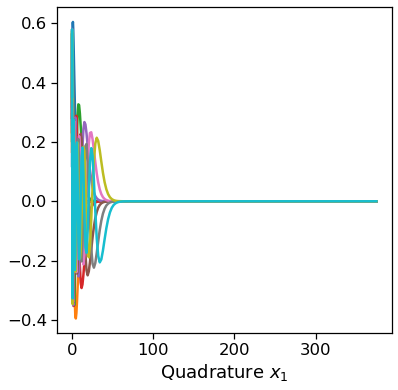

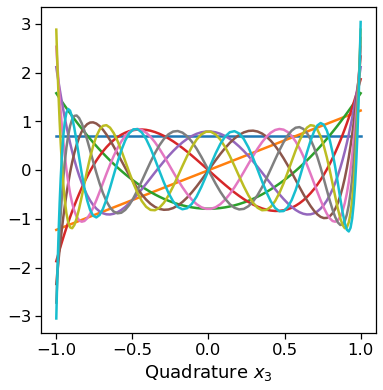

In [76]:
# number of basis functions for different coordinates
no_basis1 = 30
no_basis2 = 30
no_basis3 = 30

# number of Gaussian quadrature points for different coordinates
no_points1 = 100
no_points2 = 100
no_points3 = 100

# Laguerre quadrature/functions for r_S coordinate
print(f"Laguerre quadrature {no_points1} and basis {no_basis1} for coordinate 1")
x1, w1 = laggauss(no_points1)
w1 /= np.exp(-x1)
psi1, chol_inv1 = orthonormalise(laguerre(no_basis1, x1), w=w1)

ovlp = np.einsum("ig,jg,g->ij", psi1, psi1, w1)
print("check orthonormality, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis1))))


# Laguerre quadrature/functions for r_{CO} coordinate
print(f"Laguerre quadrature {no_points2} and basis {no_basis2} for coordinate 2")
x2, w2 = laggauss(no_points2)
w2 /= np.exp(-x2)
psi2, chol_inv2 = orthonormalise(laguerre(no_basis2, x2), w=w2)

ovlp = np.einsum("ig,jg,g->ij", psi2, psi2, w2)
print("check orthonormality, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis2))))


# Legendre quadrature/functions for theta coordinate
print(f"Legendre quadrature {no_points3} and basis {no_basis3} for coordinate 3")
x3, w3 = leggauss(no_points3)
psi3 = legendre(no_basis3, x3)

ovlp = np.einsum("ig,jg,g->ij", psi3, psi3, w3)
print("check orthonormality, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis3))))


# plot basis functions

plt.plot(x1, psi1[:10].T)
# plt.xlim([0, 100])
plt.xlabel("Quadrature $x_1$")
plt.show()

plt.plot(x3, psi3[:10].T)
plt.xlabel("Quadrature $x_3$")
plt.show()

We can now define 1D basis functions for different coordinates and their derivatives,
e.g., `func_psi1(x1)` $\rightarrow \phi_i^{(1)}(x_1)$, `func_dpsi1(x1)` $\rightarrow d\phi_i^{(1)}(x_1)/dx_1$.

In [77]:
func_psi1 = lambda x: orthonormalise(laguerre(no_basis1, x), chol_inv=chol_inv1)
func_psi2 = lambda x: orthonormalise(laguerre(no_basis2, x), chol_inv=chol_inv2)
func_psi3 = lambda x: legendre(no_basis3, x)

func_dpsi1 = lambda x: orthonormalise(laguerre_deriv(no_basis1, x), chol_inv=chol_inv1)
func_dpsi2 = lambda x: orthonormalise(laguerre_deriv(no_basis2, x), chol_inv=chol_inv2)
func_dpsi3 = lambda x: legendre_deriv(no_basis3, x)

# check that functions work, e.g., check orthonormality
ovlp = np.einsum('ig,jg,g->ij', func_psi1(x1), func_psi1(x1), w1)
print("check orthonormality for coo 1, max(|S-I|):", np.max(np.abs(ovlp - np.eye(no_basis1))))

check orthonormality for coo 1, max(|S-I|): 6.7182396467774805e-15


## Map physical coordinates into quadrature points

You may have noticed that the ranges for the quadrature coordinates `x1`, `x2`, and `x3` dont' align well with the physical coordinate ranges for $r_\text{S}$, $r_\text{CO}$, and $\theta$.

For example, print min and max values of quadrature coordinates and compare them with min and max values of Jacobi coordinates used to represent the PES for the ground electronic state of OCS.

In [78]:
xmin = np.min([x1, x2, x3], axis=-1)
xmax = np.max([x1, x2, x3], axis=-1)

rmin = potentials[0].min
rmax = potentials[0].max

for icoo in range(3):
    print(f"\nx{icoo}: [{xmin[icoo].round(3)}, {xmax[icoo].round(3)}]")
    print(f"r{icoo}: [{rmin[icoo].round(3)}, {rmax[icoo].round(3)}]")


x0: [0.014, 374.984]
r0: [1.852, 2.646]

x1: [0.014, 374.984]
r1: [0.953, 1.376]

x2: [-1.0, 1.0]
r2: [0.017, 1.047]


Therefore, it's essential to apply a transformation $f_{x\rightarrow r}$ that maps the physical coordinates' range accurately onto the quadrature grids, for example,

$$
r_\text{S}(x_1) = \sqrt{x_1 / \max(x_1)} \max(r_\text{S}), \\
r_\text{CO}(x_2) = \sqrt{x_2 / \max(x_2)} \max(r_\text{CO}), \\
\theta(x_3) = \arccos{x_3},
$$

which is implemented in function `map_x_to_r` (and its vectorised version `map_x_to_r_batch`).

Note also that when changing cooridnates from physical $(r_\text{S},r_\text{CO},\theta)$ to quadrature $(x_1,x_2,x_3)$,
the corresponding integration volume element $dr_\text{S}dr_\text{CO}d\theta$
will also change to $\left|\det{\nabla_x f_{x\rightarrow r}(x_1,x_2,x_3)}\right|dx_1dx_2dx_3$.

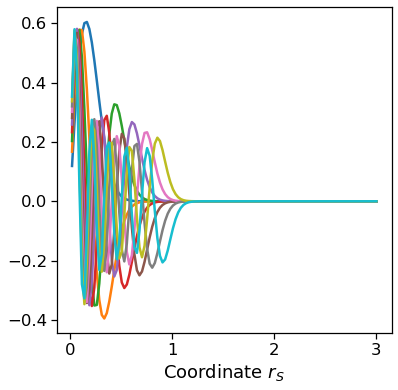

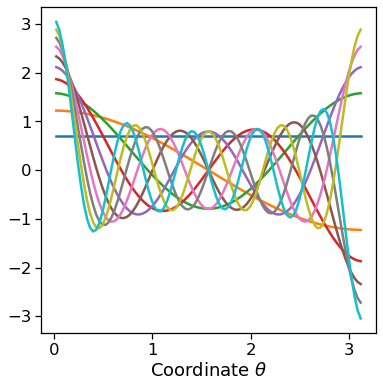

In [79]:
# serial version of mapping function
def map_x_to_r(x, xmax, rmax):
    x1, x2, x3 = x
    xmax1, xmax2 = xmax
    rmax1, rmax2 = rmax
    return jnp.array(
        [
            jnp.sqrt(x1 / xmax1) * rmax1,
            jnp.sqrt(x2 / xmax2) * rmax2,
            jnp.arccos(x3),
        ]
    )


# vectorised version of `x_to_r`
map_x_to_r_batch = jax.jit(jax.vmap(map_x_to_r, in_axes=(0, None, None)))

# max value of quadrature abscissas
xmax = np.max([x1, x2], axis=-1)

# max values for r_S and r_CO distances
rmax = [3.0, 2.0]

# compute physical coordiantes from quadratures
r1, r2, r3 = map_x_to_r([x1, x2, x3], xmax, rmax)


# plot basis functions

plt.plot(r1, psi1[:10].T)
plt.xlabel("Coordinate $r_S$")
plt.show()

plt.plot(r3, psi3[:10].T)
plt.xlabel("Coordinate $\\theta$")
plt.show()

## Build direct-product basis set

- Our task is to compute matrix elements (integrals), like, for example, PES

  $$V_{l',l} = \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}V\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)} dr_\text{S}dr_\text{CO}dr_\theta =
  \int \phi_{i'}^{(1*)}\phi_{j'}^{(2*)}\phi_{k'}^{(3*)}V\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)}
  \left|\det{\nabla_x f_{x\rightarrow r}}\right|dx_1dx_2dx_3,
  $$

  which can be approximated using Gaussian quadratures for each vibrational coordiante, as
  $$V_{l',l}\approx
  \sum_f^{N_f} \sum_g^{N_g}\sum_h^{N_h}w_f^{(1)}w_g^{(2)}w_h^{(3)}
  \phi_{i'}^{(1*)}(x_f^{(1)})\phi_{j'}^{(2*)}(x_g^{(2)})\phi_{k'}^{(3*)}(x_h^{(3)})
  V\left(r_S(x_f^{(1)}),r_{CO}(x_g^{(2)}),\theta(x_h^{(3)})\right)
  \phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)})
  \left|\det{\nabla_x f_{x\rightarrow r}(x_f^{(1)},x_g^{(2)},x_h^{(3)})}\right|.
  $$
- Introduce a multi-index for combinations of quantum numbers $l=\{i,j,k\}$, $l'=\{i',j',k'\}$ and quadrature points $p=\{f,g,h\}$, such that
  
  $$x_p=(x_f^{(1)},x_g^{(2)}, x_h^{(3)}),$$
  $$w_p = w_f^{(1)}w_g^{(2)}w_h^{(3)},$$
  $$\Phi_l(x_p)=\phi_{i}^{(1)}(x_f^{(1)})\phi_{j}^{(2)}(x_g^{(2)})\phi_{k}^{(3)}(x_h^{(3)}),$$
  and
  $$V_{l',l}=\sum_p w_p \Phi_{l'}^*(x_p)V(f_{x\rightarrow r}(x_p)) \Phi_l(x_p)
  \left|\det{\nabla_x f_{x\rightarrow r}(x_p)}\right|.
  $$

- A similar compact expression for the matrix elements of kinetic energy operator can be obtained as:

  $$
  T_{l',l}=-\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\sum_p w_p
  \Phi_{l'}^*(x_p)\frac{\partial}{\partial r_\lambda}
  G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
  \frac{\partial}{\partial r_\mu} \Phi_l(x_p)
  \left|\det{\nabla_x f_{x\rightarrow r}(x_p)}\right| = \\
  =\frac{1}{2}\sum_{\lambda,\mu}^{3N-6}\sum_p w_p
  \frac{\partial\Phi_{l'}^*(x_p)}{\partial r_\lambda}
  G_{\lambda,\mu}(f_{x\rightarrow r}(x_p))
  \frac{\partial\Phi_l(x_p)}{\partial r_\mu} 
  \left|\det{\nabla_x f_{x\rightarrow r}(x_p)}\right|,
  $$
  
  where $r_\lambda, r_\mu \in \{r_\text{S}, r_\text{CO}, \theta\}$.

  $$
  \frac{\partial\Phi_l(x_p)}{\partial r_\mu} =
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\frac{\partial x_p}{\partial r_\mu} = 
  \frac{\partial\Phi_l(x_p)}{\partial x_p}\cdot\left(\nabla_x f_{x\rightarrow r}\right)^{-1}
  $$

<!-- Build truncated product of quantum numbers:

$$\Phi_{l} = \phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)},~~~l = \{i, j,k\},$$

such that weighted sum of quantum numbers is smaller than truncation parameter
$$w_1i+w_2j+w_3k\leq L_\text{max}.$$

Store multi-index $l$ in arrray `quanta[l]=(i, j, k)` -->

In [22]:
quanta1 = np.arange(0, 10)
quanta2 = np.arange(0, 10)
quanta3 = np.arange(0, 10)
max_sum_quanta = 10
weights_sum_quanta = np.array([2, 2, 1])

quanta = np.array(
    [
        elem
        for elem in itertools.product(quanta1, quanta2, quanta3)
        if np.sum(elem * weights_sum_quanta) <= max_sum_quanta
    ]
)  # shape = (no. basis funcs, 3)

print("total number of basis functions:", len(quanta))

total number of basis functions: 90


$$\langle \Phi_{l'}|V|\Phi_l\rangle= \langle \phi_{i'}^{(1)}\phi_{j'}^{(2)}\phi_{k'}^{(3)}|V|\phi_i^{(1)}\phi_j^{(2)}\phi_k^{(3)}\rangle\approx\\
\sum_f^{N_f} \sum_g^{N_g}\sum_h^{N_h}\underbrace{w_f^{(1)}w_g^{(2)}w_h^{(3)}}_{W}
\underbrace{\phi_{i'}^{(1)}(r_f^{(1)})\phi_{j'}^{(2)}(r_g^{(2)})\phi_{k'}^{(3)}(r_h^{(3)})}_{\Phi_{l'}} V(r_f^{(1)},r_g^{(2)},r_h^{(3)})
\underbrace{\phi_{i}^{(1)}(r_f^{(1)})\phi_{j}^{(2)}(r_g^{(2)})\phi_{k}^{(3)}(r_h^{(3)})}_{\Phi_l}
$$
Build direct product of one-dimensional quadratures:
$$\Phi_{l} = \phi_i^{(1)}(x_f^{(1)})\phi_j^{(2)}(x_g^{(2)})\phi_k^{(3)}(x_h^{(3)}),~~~l = \{i, j,k\},$$

$$ X = \{x_f^{(1)}, x_g^{(2)}, x_h^{(3)} \},$$
$$ W = w_f^{(1)}w_g^{(2)}w_h^{(3)}, $$
$$ \text{for}~f=1..N_f,g=1..N_g,h=1..N_h, $$

where $N$ is the number of quadrature points in each dimension.

Here, $x_f^{(1)}$=`x1`, $x_g^{(2)}$=`x2`, $x_h^{(3)}$=`x3`,

$w_f^{(1)}$=`w1`, $w_g^{(2)}$=`w2`, $w_h^{(3)}$=`w3`,

and $X$=`points`, $W$=`weights`.

In [25]:
points = np.stack(
    [elem.ravel() for elem in np.meshgrid(x1, x2, x3)], axis=-1
)  # shape = (no. quad. points, 3)

weights = np.prod(np.stack(
    [elem.ravel() for elem in np.meshgrid(w1, w2, w3)], axis=-1
), axis=-1)

print("total number of quadrature points:", len(points))


jacobi_coords = jax.vmap(x_to_r, in_axes=(0, None, None))(points, xmax, rmax)
V0 = (potentials[2].pes(jacobi_coords) - potentials[2].e0) * hartree_to_invcm
# ind = np.where(np.abs(V0)<100000)
# jacobi_coords = jacobi_coords[ind]

total number of quadrature points: 1000000


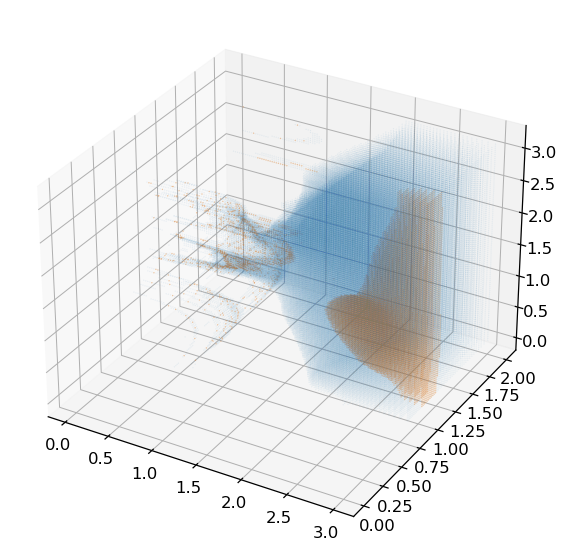

In [33]:

ind1 = np.where(np.abs(V0)<100000)
ind2 = np.where(np.abs(V0)<10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(*jacobi_coords[ind1].T, s=0.01, alpha=0.3)
ax.scatter(*jacobi_coords[ind2].T, s=0.1, alpha=0.5)
plt.show()

Evaluate kinetic and potential operators on quadrature grid

In [63]:
jacobi_coords = jax.vmap(x_to_r, in_axes=(0, None, None))(points, xmax, rmax)

# kinetic-energy matrix (in cm^-1)
G = Gmat_batch(jacobi_coords, jacobi_to_cartesian)
G = G[:, :3, :3]  # select only vibrational part

# potentials for ground and excited states (in cm^-1)
V0 = (potentials[1].pes(jacobi_coords) - potentials[1].e0) * hartree_to_invcm

Evaluate producs of basis functions:
$$\Phi_{i,j,k}(x_f^{(1)},x_g^{(2)},x_h^{(3)}) = \phi_i(x_f^{(1)})\phi_j(x_g^{(2)})\phi_k(x_h^{(3)})  $$

In [68]:
x1, x2, x3 = points.T
q1, q2, q3 = quanta.T

psi = func_psi1(x1)[q1] * func_psi2(x2)[q2] * func_psi3(x3)[q3]

In [69]:
dpsi = np.array(
    [
        func_dpsi1(x1)[q1] * func_psi2(x2)[q2] * func_psi3(x3)[q3],
        func_psi1(x1)[q1] * func_dpsi2(x2)[q2] * func_psi3(x3)[q3],
        func_psi1(x1)[q1] * func_psi2(x2)[q2] * func_dpsi3(x3)[q3],
    ]
)


$$
\mathbf{r} = f_c(\mathbf{x}),~~~\mathbf{x} = f_c^{-1}(\mathbf{r})
$$

for example, $\theta=\arccos(x)$.

$$ \hat{T} = -\frac{1}{2} \sum_{\lambda=1..3}\sum_{\mu=1..3} \frac{\partial}{\partial r_\lambda}G_{\lambda,\mu}(r_1,r_2,r_3)\frac{\partial}{\partial r_\mu} $$

$$
\langle \psi_k(\mathbf{x}) |V |\psi_l(\mathbf{x}) \rangle =
\int \psi_k(\mathbf{x})V(\mathbf{r})\psi_l(\mathbf{x})d\mathbf{r}
$$

$$
\langle \psi_k(\mathbf{x}) |\hat{T} |\psi_l(\mathbf{x}) \rangle =
\frac{1}{2} \sum_{\lambda=1..3}\sum_{\mu=1..3} \int \frac{\partial\psi_k(\mathbf{x})}{\partial r_\lambda} G_{\lambda,\mu}(\mathbf{r})\frac{\partial\psi_l(\mathbf{x})}{\partial r_\mu} d\mathbf{r}
$$

$$
\frac{\partial \psi_k(\mathbf{x})}{\partial r_\lambda} = \frac{\partial \psi_k(\mathbf{x})}{\partial \mathbf{x}}\cdot\frac{\partial \mathbf{x}}{\partial r_\lambda}
$$

$$
d\mathbf{r} = \left|\det{\nabla_\mathbf{x} \mathbf{r}}\right|d\mathbf{x} = 1 / \left|\det{\nabla_\mathbf{r} \mathbf{x}}\right|d\mathbf{x}
$$




$$|p\rangle(x) = \sqrt{W(x)}L_p(x)$$


$$|n\rangle = \sum_{p+q+r\leq N} c_{p,q,r} |p\rangle|q\rangle|r\rangle$$

$$\langle n'|\hat{H}|n\rangle = \sum_{p'+q'+r'\leq N}\sum_{p+q+r\leq N}c_{p',q',r'}^* c_{p,q,r}\langle p'|\langle q'|\langle r'|\hat{H}|r\rangle|q\rangle|p\rangle$$

In [72]:
dx_dr = jax.jit(jax.vmap(jax.jacrev(x_to_r, argnums=0), in_axes=(0, None, None)))(
    points, xmax, rmax
)

In [20]:
print(jac_val.shape, psi.shape, dpsi.shape)

dpsi_ = np.einsum('xig,gxl->lig', dpsi, jac_val, optimize='optimal')

# keo = np.einsum('lig,mjg,g->', dpsi_, dpsi_, 1/det)
print(dpsi_.shape)

(1000000, 3, 3) (90, 1000000) (3, 90, 1000000)
